In [153]:
library(sicegar)
library(dplyr)
library(tibble)
library(tidyr)
library(readr)
library(stringr)
library(purrr)
library(here)
library(lubridate)
library(ggplot2)
library(scales)



# Data Import and Preparation

We are working with 21 years of data 2000-2020, 14 stations and 3 species leading to a total of 882 data sets.

In [154]:
pollen_daily <- read_delim(paste0(here(), "/data/dwh/pollen_dwh_daily.txt"), delim = " ", skip = 17, trim_ws = TRUE)
pollen_daily %<>% 
    mutate(across(is.numeric, ~ if_else(. < 0, NA_real_, .)),
    datetime = ymd_hm(paste0(YYYY, "-", sprintf("%02d", MM), "-", sprintf("%02d", DD), " ", sprintf("%02d", HH), ":", sprintf("%02d", mm))),
    year = year(datetime)) %>%
    filter(year <= 2020) %>%
    select(-(YYYY:mm)) %>%
    setNames(tolower(names(.))) %>%
    pivot_longer(plo:pcf, names_to = "station", values_to = "conc")

pollen_split <- pollen_daily %>%
    split(list(.$year, .$station, .$parameter))

larger_ten <- function(x) x > 0
season_start <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten))
season_end <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten, .dir = "backward"))



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [155]:
pollen_season <- pmap(list(pollen_split, season_start, season_end), ~
  ..1 %>%
    slice(..2:..3) %>%
    rowid_to_column("day")) 

# This takes 100sek, wondering whether there is a more efficient solution
pollen_join <- pollen_season %>% bind_rows()

In [156]:
pollen_mean_species <- pollen_join %>%
  group_by(day, parameter, station) %>%
  summarise(conc = mean(conc, na.rm = TRUE)) %>%
  ungroup %>%
  split(.$parameter)


`summarise()` has grouped output by 'day', 'parameter'. You can override using the `.groups` argument.



## Timeseries 

this too

Warning message:
“Removed 231 rows containing missing values (position_stack).”
Warning message:
“Removed 72 rows containing missing values (position_stack).”


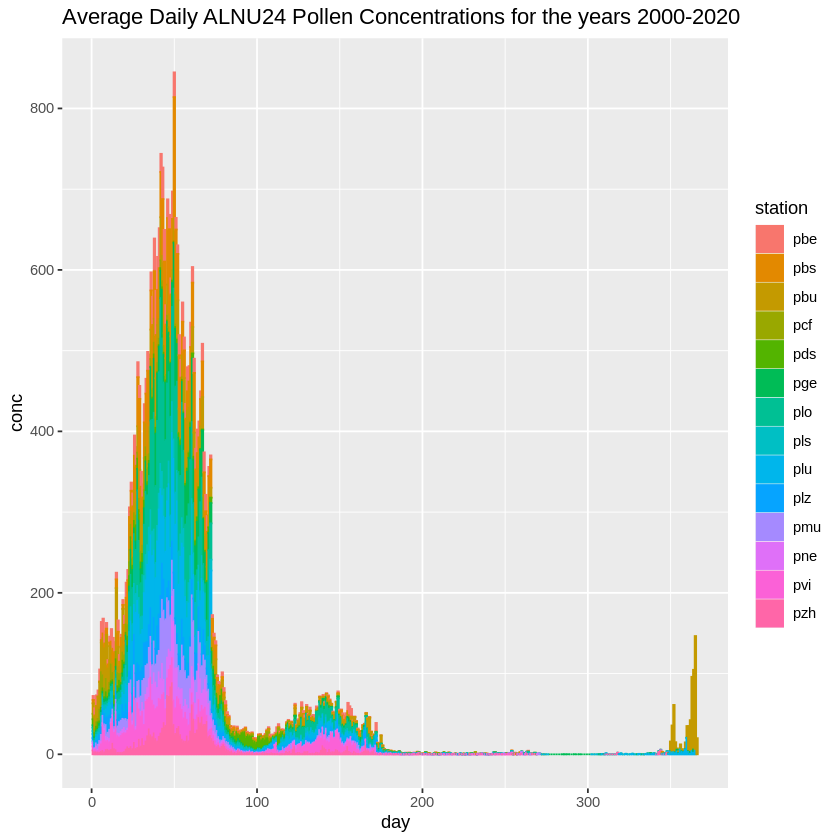

Warning message:
“Removed 76 rows containing missing values (position_stack).”


$ALNU24

$BETU24

$POAC24


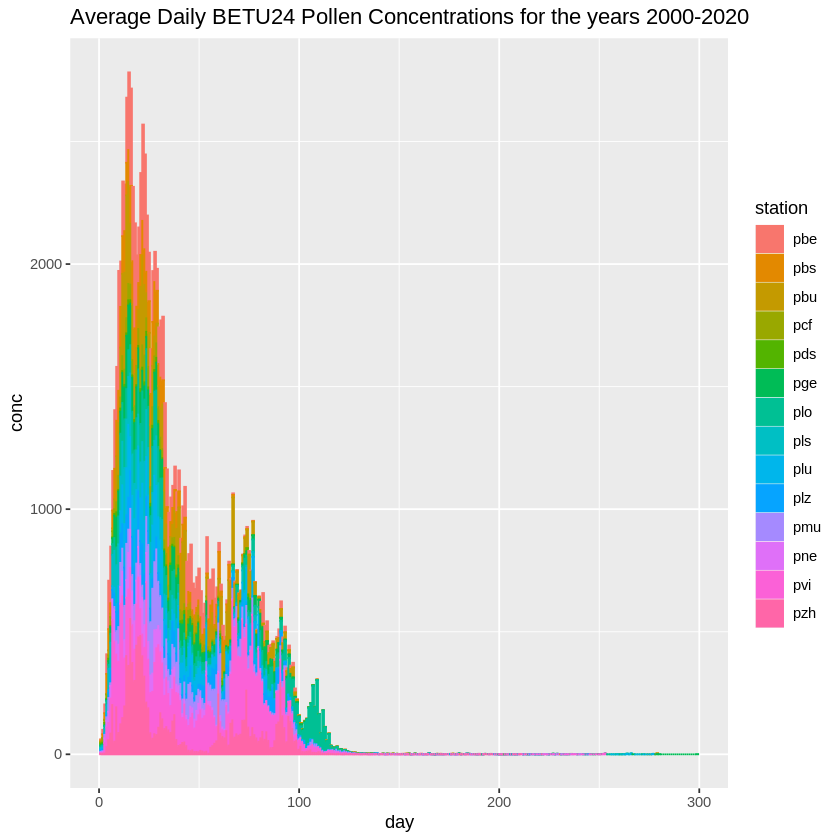

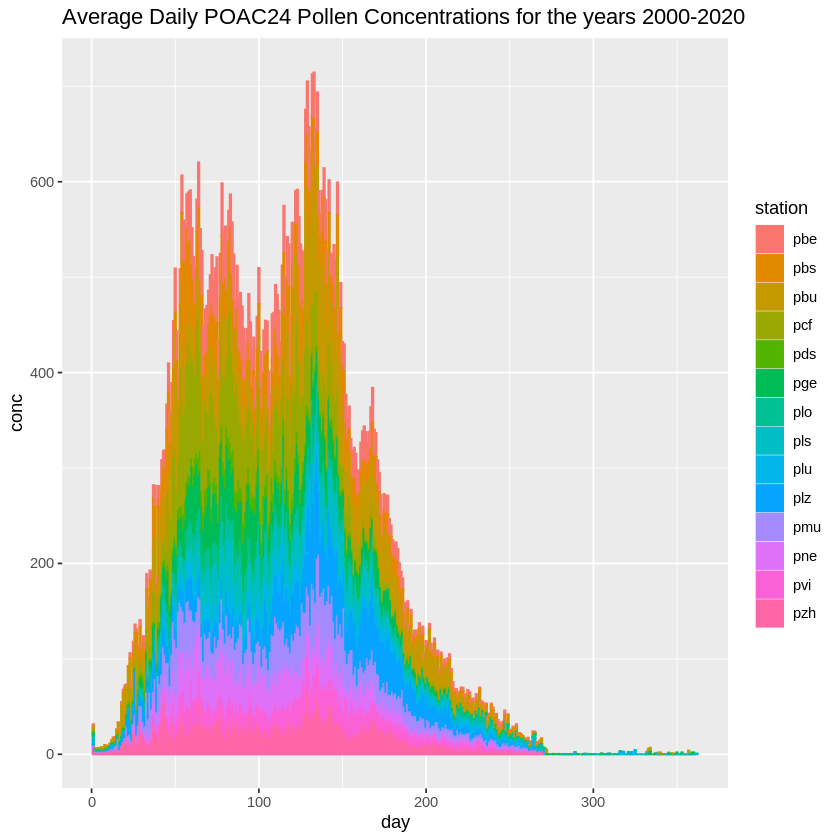

In [157]:
map(pollen_mean_species, ~
    ggplot(.x, aes(x = day, y = conc, col = station, fill = station)) +
    geom_col() +
    ggtitle(paste("Average Daily", unique(.x$parameter), "Pollen Concentrations for the years 2000-2020")))

In [158]:
pollen_sum_day <- map(pollen_mean_species, ~ .x %>%
  group_by(day, parameter) %>%
  summarise(conc = sum(conc, na.rm = TRUE)) %>%
  ungroup %>%
  mutate(conc = rescale(conc, to = c(0, 1.22))) %>%
  select(time = day, intensity = conc))



`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'day'. You can override using the `.groups` argument.



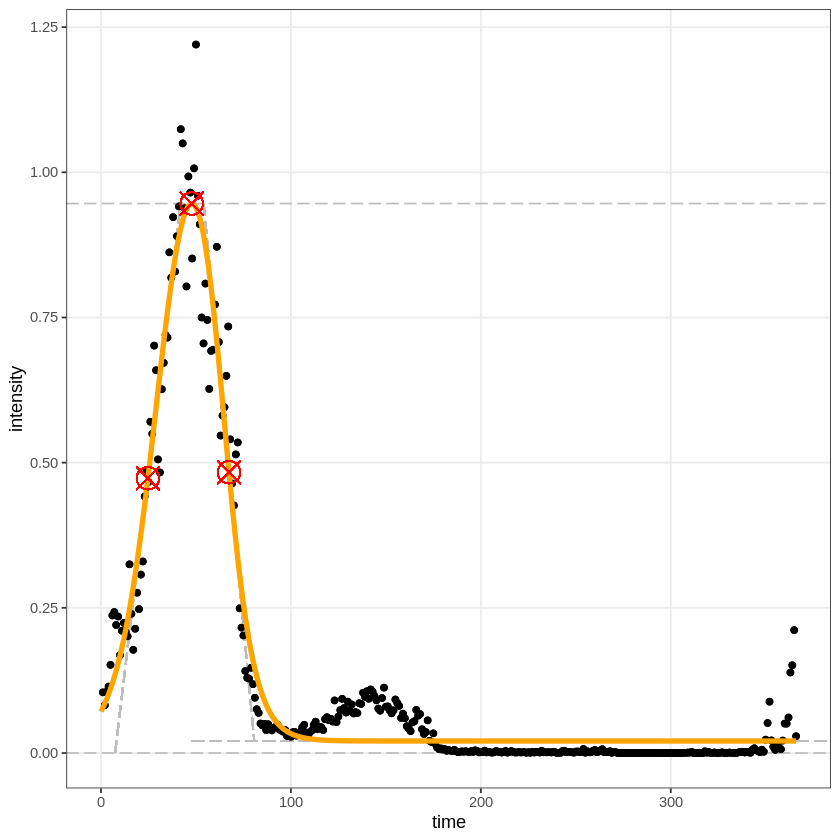

$ALNU24
$ALNU24[[1]]

$ALNU24[[2]]
# A tibble: 70 x 2
   name                                    value                
   <chr>                                   <chr>                
 1 finalAsymptoteIntensityRatio_N_Estimate 0.021841550733675    
 2 finalAsymptoteIntensityRatio_Std_Error  0.0034843735703798   
 3 finalAsymptoteIntensityRatio_t_value    6.26842968829379     
 4 finalAsymptoteIntensityRatio_Pr_t       1.04352869622321e-09 
 5 maximum_N_Estimate                      0.775588466974723    
 6 maximum_Std_Error                       0.0116605094363564   
 7 maximum_t_value                         66.5141151171755     
 8 maximum_Pr_t                            2.57236752989296e-204
 9 slope1Param_N_Estimate                  34.0543003854938     
10 slope1Param_Std_Error                   2.88982996237079     
# … with 60 more rows


$BETU24
$BETU24[[1]]

$BETU24[[2]]
# A tibble: 71 x 2
   name                                    value                
   <chr>               

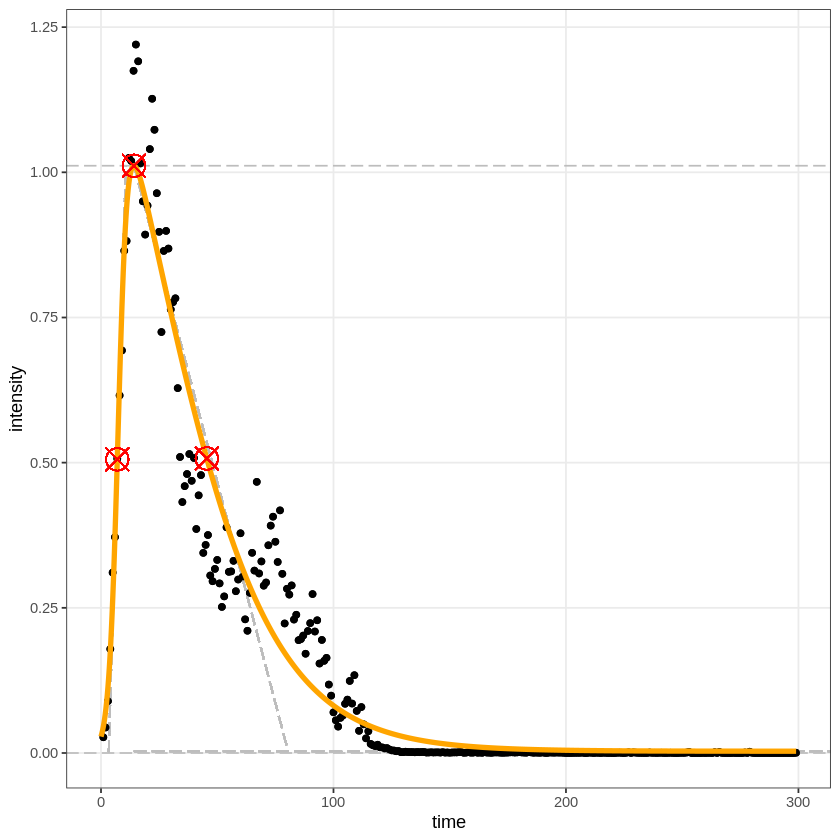

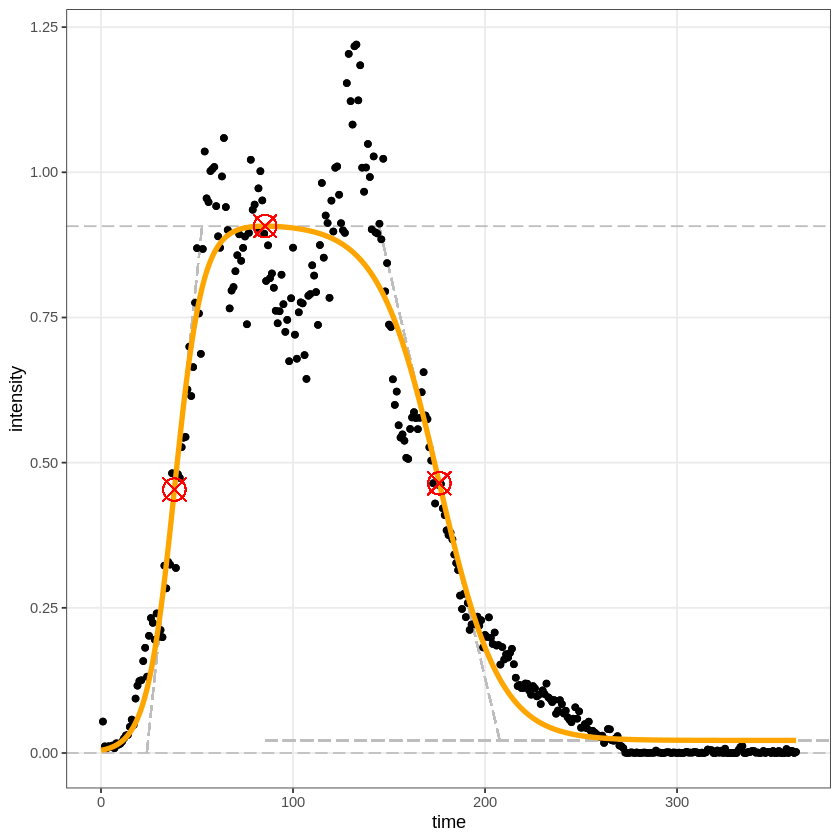

In [159]:
fit_curve <- function(x) {
  normalizedInput <- normalizeData(dataInput = x, 
                                   dataInputName = "doubleSigmoidalSample")
  # Fit double-sigmoidal model
  doubleSigmoidalModel <- multipleFitFunction(dataInput = normalizedInput,
                                              model = "doublesigmoidal",
                                              n_runs_min = 20,
                                              n_runs_max = 500,
                                              showDetails = FALSE)                                                
  # Calculate additional parameters
  doubleSigmoidalModel <- parameterCalculation(doubleSigmoidalModel)

  # Plotting the model
  plot <- figureModelCurves(dataInput = normalizedInput,
  doubleSigmoidalFitVector = doubleSigmoidalModel,
  showParameterRelatedLines = TRUE)

  # Table with parameters
  params <- parameterCalculation(doubleSigmoidalModel)
  params %<>% 
    mutate(across(everything(), as.character)) %>%
    pivot_longer(everything())

  return(list(plot, params))

}
fitted_curves <- map(pollen_sum_day, ~ fit_curve(.x))

# Display optimized for Jupyter Notebooks
fitted_curves



## Comparison with the curves currently used in COSMO
The first factor is a scaling factor
The second factor describes the ascending slope
The third factor describes the descendig slope


For the double-sigmoidal model, key parameters describing the curve are:

    maximum: The maximum intensity the double-sigmoidal curve reaches.
    final asymptotic intensity: The intensity the curve decreases to after having reached its maximum.
    midpoint 1: The time point at which the double-sigmoidal curve reaches half of its maximum intensity during the initial rise.
    slope 1: The slope at midpoint 1.
    midpoint 2: The time point at which the double-sigmoidal curve reaches the intensity corresponding to the mean of the maximum intensity and the final asymptotic intensity.
    slope 2: The slope at midpoint 2.

https://cran.r-project.org/web/packages/sicegar/vignettes/introduction.html

[1] 80.69355

[1] 0.9462179

[1] 0.09304454

[1] 30.5228

[1] 0.125238

[1] 63.36118

Warning message:
“Removed 267 rows containing missing values (geom_point).”
Warning message:
“Removed 267 rows containing missing values (geom_point).”
Warning message:
“Removed 727 row(s) containing missing values (geom_path).”


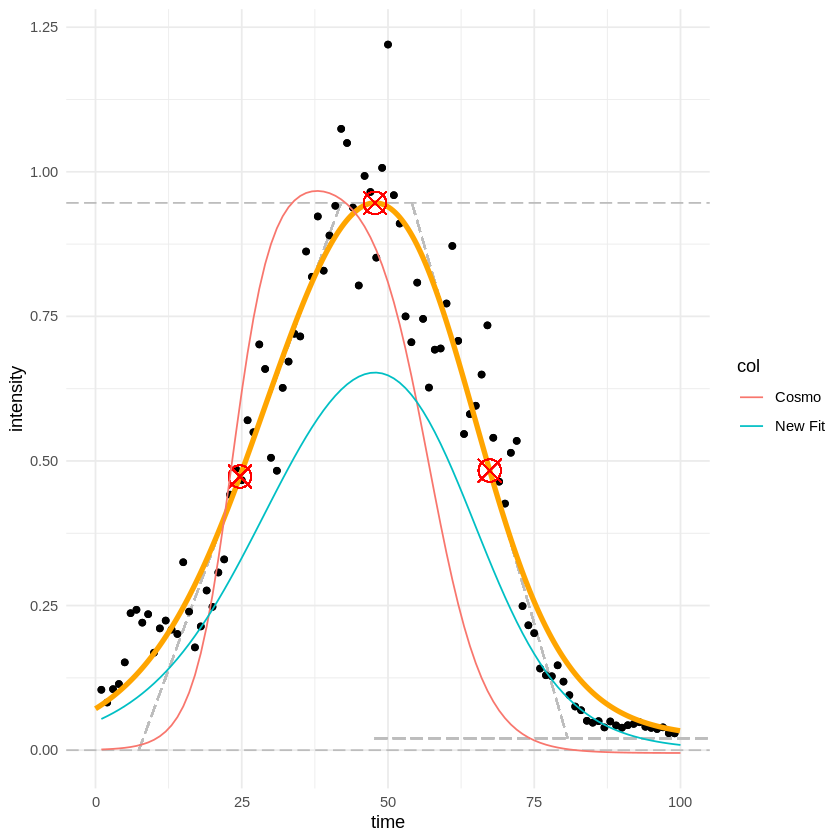

In [167]:
# ALNUS

params_alnus <- fitted_curves[["ALNU24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:100
saisl  <- max_length

y_cosmo <- (exp(-0.152 * saisl + 6) + 1) * (1 / (1 + exp(-x * 0.3 + 7))) * 
           (1 / (1 + exp(17 / saisl * x - 12)) - 0.005)

y_new_fit <- (0 + (maximum)/(1 + exp((-slope1) * (x - midpoint1)))) *
             (0 + (maximum)/(1 + exp((slope2) * (x - midpoint2))))


data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

max_length
maximum
slope1
midpoint1
slope2
midpoint2

fitted_curves[["ALNU24"]][[1]] +
  scale_x_continuous(limits = c(0, 100)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

[1] 80.4548

[1] 0.5027263

Warning message:
“Removed 199 rows containing missing values (geom_point).”
Warning message:
“Removed 199 rows containing missing values (geom_point).”
Warning message:
“Removed 666 row(s) containing missing values (geom_path).”


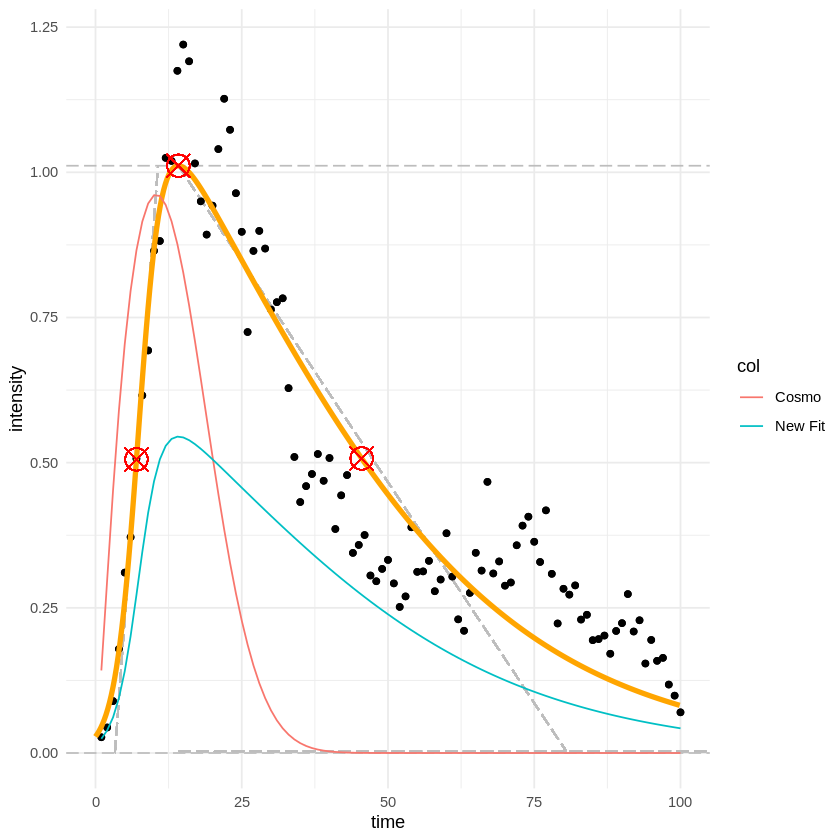

In [161]:
# BETULA

params_alnus <- fitted_curves[["BETU24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:100
saisl  <- max_length

y_cosmo <- 2 * (1 / (1 + exp(- x *0.5)) - 0.5) * exp(-((0.08 * x - 0.8) * 
(0.08 * x - 0.8)))* (1/(1 + exp((log(39) + 8)/saisl * x - 8)) - 0.025)

y_new_fit <- (0 + (maximum - 0)/(1 + exp((-slope1) * (x - midpoint1)))) *
             (0 + (maximum - 0)/(1 + exp((slope2) * (x - midpoint2))))


data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

max_length
slope1

fitted_curves[["BETU24"]][[1]] +
  scale_x_continuous(limits = c(0, 100)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

[1] 207.6318

[1] 0.1381844

Warning message:
“Removed 112 rows containing missing values (geom_point).”
Warning message:
“Removed 112 rows containing missing values (geom_point).”
Warning message:
“Removed 310 row(s) containing missing values (geom_path).”


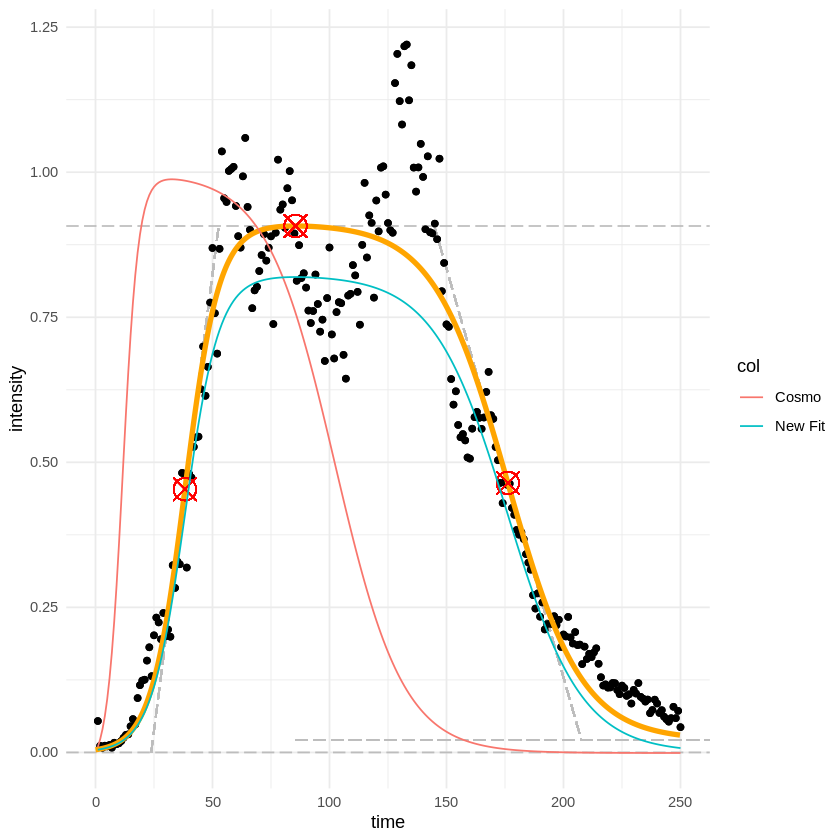

In [162]:
# POACEAE

params_alnus <- fitted_curves[["POAC24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:250
saisl  <- max_length

y_cosmo <- 1.03 * (1/(1 + exp(-0.3 * x + 3.5)) - 0.03)* 
          (1/(1 + exp((log(499) + 8)/saisl * x - 7)) - 0.001)
y_new_fit <- (0 + (maximum - 0)/(1 + exp((-slope1) * (x - midpoint1)))) *
             (0 + (maximum - 0)/(1 + exp((slope2) * (x - midpoint2))))


data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

max_length
slope1

fitted_curves[["POAC24"]][[1]] +
  scale_x_continuous(limits = c(0, 250)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

In [163]:
sigmoidalFitFormula

function (x, maximum, slopeParam, midPoint) 
{
    y = (0 + (maximum - 0)/(1 + exp((-slopeParam) * (x - midPoint))))
    return(y)
}
<bytecode: 0x55dc656f3180>
<environment: namespace:sicegar>

In [164]:
doublesigmoidalFitFormula

function (x, finalAsymptoteIntensityRatio, maximum, slope1Param, 
    midPoint1Param, slope2Param, midPointDistanceParam) 
{
    if (slope1Param < 0) {
        stop("slope1Param should be a positive number")
    }
    if (slope2Param < 0) {
        stop("slope2Param should be a positive number. It is the absolute value of the second slopeParam")
    }
    if (midPointDistanceParam < 0) {
        stop("midPointDistanceParam should be a positive number. It is the distance between two steppest points of exponential phase and lysis")
    }
    if (finalAsymptoteIntensityRatio < 0 | finalAsymptoteIntensityRatio > 
        1) {
        stop("finalAsymptoteIntensityRatio should be a number between 0 and 1")
    }
    if (maximum < 0) {
        stop("maximum should be a positive number")
    }
    optimizeIntervalMin <- midPoint1Param - 2 * midPointDistanceParam
    optimizeIntervalMax <- midPoint1Param + 3 * midPointDistanceParam
    xmax <- stats::optimize(f1, c(optimizeIntervalMin, optimizeIntervalMax), 
        tol = 1e-04, B1 = slope1Param, M1 = midPoint1Param, B2 = slope2Param, 
        L = midPointDistanceParam, maximum = TRUE)
    argumentt <- xmax$maximum
    constt <- f0(argumentt, slope1Param, midPoint1Param, slope2Param, 
        midPointDistanceParam)
    y <- f2(x, finalAsymptoteIntensityRatio, maximum, slope1Param, 
        midPoint1Param, slope2Param, midPointDistanceParam, constt, 
        argumentt)
    return(y)
}
<bytecode: 0x55dc63ebc6d0>
<environment: namespace:sicegar>